In [1]:
# Rulează o singură dată
!pip install -q imbalanced-learn shap


In [2]:
#manipulare date
import numpy as np
import pandas as pd
#figuri
import matplotlib.pyplot as plt
import seaborn as sns

#model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.decomposition import PCA

#pentru imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
# Dacă ai upload direct în Colab:
df = pd.read_csv('/content/drive/MyDrive/AMDA/alzheimers_disease_data.csv')

df.shape, df.columns


((2149, 35),
 Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
        'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
        'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
        'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
        'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
        'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
        'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
        'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
        'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
       dtype='object'))

In [4]:
# primele rânduri
display(df.head())

# tipuri și lipsuri
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(20))

# distribuția țintei
print("Diagnosis value counts:")
print(df['Diagnosis'].value_counts(normalize=False))
print(df['Diagnosis'].value_counts(normalize=True))


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

None

,0
PatientID,0
Age,0
Gender,0
Ethnicity,0
EducationLevel,0
BMI,0
Smoking,0
AlcoholConsumption,0
PhysicalActivity,0
DietQuality,0


Diagnosis value counts:
Diagnosis
0    1389
1     760
Name: count, dtype: int64
Diagnosis
0    0.646347
1    0.353653
Name: proportion, dtype: float64


In [5]:
#procesul de data cleaning
# elimină coloana ID dacă există
if 'PatientID' in df.columns:
    df = df.drop(columns=['PatientID'])

# target
y = df['Diagnosis']
X = df.drop(columns=['Diagnosis'])

# În cazul în care există coloane confidențiale/irrelevante:
for col in ['DoctorInCharge', 'XXXConfid','Doctor']:
    if col in X.columns:
        X = X.drop(columns=[col])

# split stratificat pentru păstrarea distribuției clasei
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

X_train.shape, X_test.shape


((1719, 32), (430, 32))

In [6]:
#ma asigur ca tratez corect datele numerice si categorice
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# Unele coloane codificate numeric pot fi de fapt categorice (ex: Gender, Ethnicity, EducationLevel)
# Din descriere: Gender, Ethnicity, EducationLevel, Smoking, etc. sunt kodificate numeric → tratăm ca numerice binare/categorice?
# Ajustare sugerată (dacă vrei să tratezi codificate ca categorical):
maybe_categorical = ['Gender','Ethnicity','EducationLevel','Smoking','FamilyHistoryAlzheimers',
                     'CardiovascularDisease','Diabetes','Depression','HeadInjury','Hypertension',
                     'MemoryComplaints','BehavioralProblems','Confusion','Disorientation',
                     'PersonalityChanges','DifficultyCompletingTasks','Forgetfulness']

for c in maybe_categorical:
    if c in num_cols:
        # mută în cat_cols pentru a fi one-hot-encoded
        num_cols.remove(c)
        cat_cols.append(c)

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)


Numerical columns: ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']
Categorical columns: ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']


In [7]:
# 1. Pipeline pentru datele NUMERICE:
# - Pasul 1 (Imputer): Înlocuim valorile lipsă cu Mediana. Alegem mediana și nu media
#   pentru că este mai robustă la valori extreme (outliers).
# - Pasul 2 (Scaler): Aplicăm StandardScaler pentru a aduce datele la medie 0 și deviație 1.
#   CRITIC PENTRU REGRESIA LOGISTICĂ: Fără scalare, variabilele cu valori mari (ex: Colesterol)
#   ar domina variabilele cu valori mici (ex: Vârsta), distorsionând coeficienții modelului.
# imputer + scaler pentru numerice
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Pipeline pentru datele CATEGORICE:
# - Pasul 1 (Imputer): Înlocuim valorile lipsă cu valoarea cea mai frecventă (Modul).
# - Pasul 2 (OneHot): Transformăm categoriile (ex: Etnie 0,1,2,3) în coloane binare separate.
#   MOTIV: Evităm "Label Encoding" care ar induce o relație falsă de ordine (ex: ar sugera
#   că Etnia 3 este "mai mare" matematic decât Etnia 1, ceea ce este fals biologic).
# imputer + onehot pentru categorice
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV ROC-AUC: 0.9010117771467205

--- Top 5 Cele mai bune combinații de parametri ---


,param_clf__C,param_clf__penalty,param_clf__solver,Mean ROC-AUC,Std Dev,Rank
2,1.00,l2,lbfgs,0.901012,0.013835,1
1,0.10,l2,lbfgs,0.900808,0.013960,2
3,10.00,l2,lbfgs,0.900798,0.014007,3
0,0.01,l2,lbfgs,0.891583,0.015157,4


/tmp/ipython-input-1937617479.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='Mean ROC-AUC', y='Configuration', palette='viridis', orient='h')


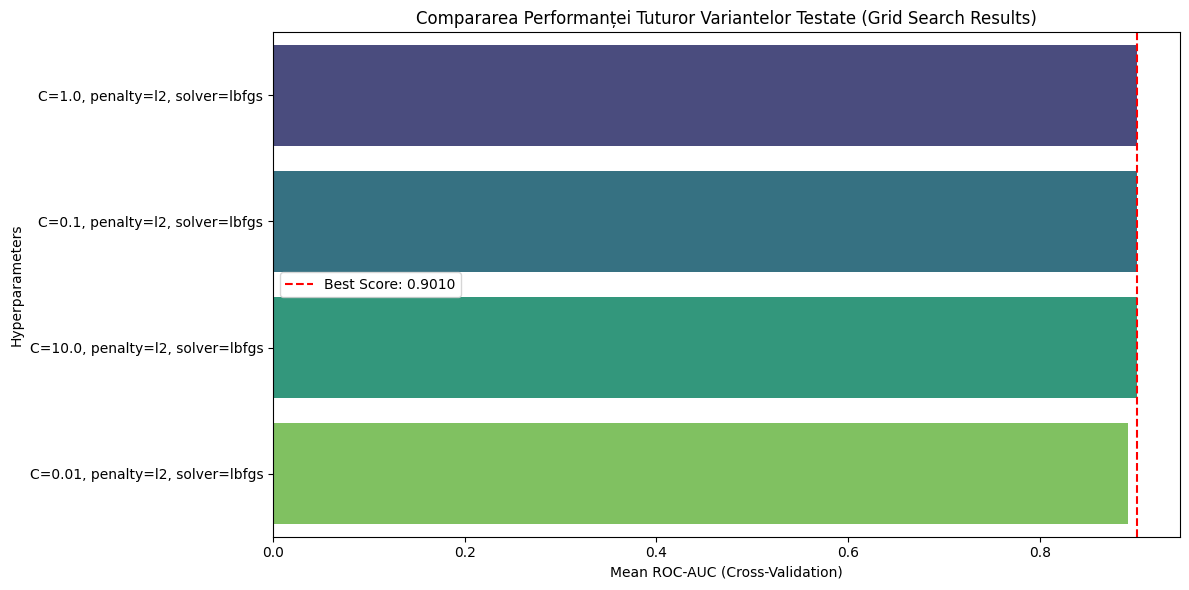

In [8]:
# folosim SMOTE pe setul de antrenament (imb pipeline)
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor), #pasul1: curatare si scalare
    ('smote', SMOTE(random_state=RANDOM_STATE)), #pas 2: generare date sintetice pt echilibrare
    ('clf', log_reg) #clasificatorul: modelul matematic
])

#Dacă foloseai pipeline-ul standard, SMOTE s-ar fi aplicat greșit (poate și pe datele de validare).

#ImbPipeline știe automat că SMOTE se aplică DOAR pe datele de antrenament (fit), dar este sărit când facem predicții (predict). Astfel, eviți Data Leakage (trișarea).

# grid de hiperparametri (regularizare)
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)
# ==============================================================================
# ANALIZA DETALIATĂ A REZULTATELOR GRID SEARCH
# ==============================================================================

# 1. Extragem rezultatele într-un DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# 2. Selectăm doar coloanele care ne interesează
# (Parametrii testați și scorul mediu/deviația standard)
# Identificăm dinamic coloanele de parametri (cele care încep cu 'param_')
param_cols = [col for col in results_df.columns if col.startswith('param_')]
cols_to_keep = param_cols + ['mean_test_score', 'std_test_score', 'rank_test_score']

comparison_df = results_df[cols_to_keep].copy()

# 3. Redenumim pentru claritate
comparison_df.rename(columns={'mean_test_score': 'Mean ROC-AUC',
                              'std_test_score': 'Std Dev',
                              'rank_test_score': 'Rank'}, inplace=True)

# 4. Sortăm după performanță
comparison_df = comparison_df.sort_values(by='Rank')

print("\n--- Top 5 Cele mai bune combinații de parametri ---")
display(comparison_df.head(5))

# ==============================================================================
# VIZUALIZARE COMPARATIVĂ
# ==============================================================================
plt.figure(figsize=(12, 6))

# Creăm o etichetă unică pentru fiecare variantă (ex: "C=0.1, L1")
# Asta ajută la afișarea pe axa X
def make_label(row):
    label_parts = [f"{col.replace('param_clf__', '')}={val}" for col, val in zip(param_cols, row[param_cols])]
    return ", ".join(label_parts)

comparison_df['Configuration'] = results_df.apply(make_label, axis=1)

# Plotăm Bar Chart cu bare de eroare (Std Dev)
sns.barplot(data=comparison_df, x='Mean ROC-AUC', y='Configuration', palette='viridis', orient='h')

# Adăugăm o linie verticală pentru cel mai bun scor
best_score = grid.best_score_
plt.axvline(best_score, color='red', linestyle='--', label=f'Best Score: {best_score:.4f}')

plt.title('Compararea Performanței Tuturor Variantelor Testate (Grid Search Results)')
plt.xlabel('Mean ROC-AUC (Cross-Validation)')
plt.ylabel('Hyperparameters')
plt.legend()
plt.tight_layout()
plt.savefig('grid_search_comparison.png', bbox_inches='tight')
plt.show()


In [9]:
best_model = grid.best_estimator_

# predictii
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# metrici
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1: {f1:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")


Test Accuracy: 0.8116
Test Precision: 0.6940
Test Recall: 0.8355
Test F1: 0.7582
Test ROC-AUC: 0.8858


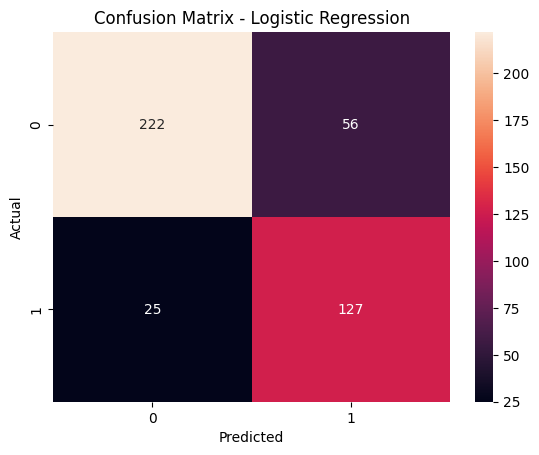

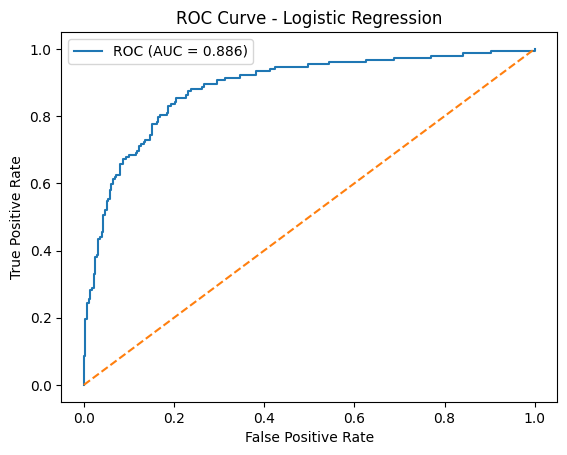

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_logreg.png', bbox_inches='tight')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.savefig('roc_logreg.png', bbox_inches='tight')
plt.show()


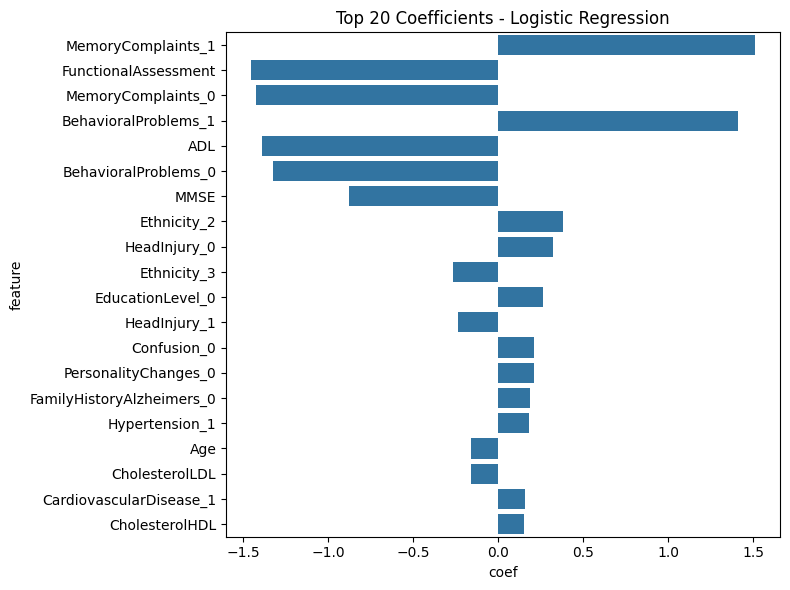

In [11]:
# extragem numele caracteristicilor după column transformer
# funcție utilitară:
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
            ohe = transformer.named_steps['onehot']
            cats = ohe.get_feature_names_out(columns)
            feature_names.extend(cats)
        else:
            feature_names.extend(columns)
    return feature_names

feat_names = get_feature_names_from_column_transformer(best_model.named_steps['preproc'])
coef = best_model.named_steps['clf'].coef_.flatten()

feat_coef = pd.DataFrame({'feature': feat_names, 'coef': coef})
feat_coef['abs_coef'] = feat_coef['coef'].abs()
feat_coef = feat_coef.sort_values(by='abs_coef', ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x='coef', y='feature', data=feat_coef)
plt.title('Top 20 Coefficients - Logistic Regression')
plt.tight_layout()
plt.savefig('coefficients_logreg.png', bbox_inches='tight')
plt.show()


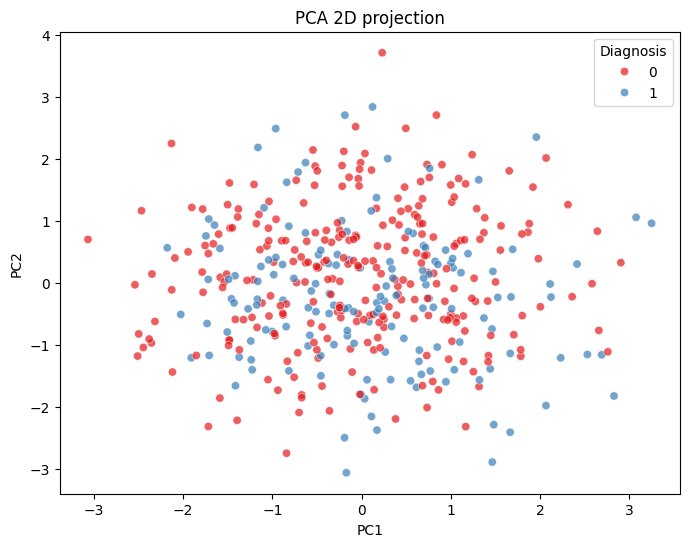

In [12]:
# PCA doar pe setul de test procesat
X_test_transformed = best_model.named_steps['preproc'].transform(X_test)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_test_transformed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_test, palette='Set1', alpha=0.7)
plt.title('PCA 2D projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('pca_2d_logreg.png', bbox_inches='tight')
plt.show()


In [13]:
scoring = ['accuracy','precision','recall','f1','roc_auc']
cv_results = {}
for s in scoring:
    scores = cross_val_score(grid.best_estimator_, X, y, cv=cv, scoring=s, n_jobs=-1)
    cv_results[s] = {'mean': np.mean(scores), 'std': np.std(scores)}

pd.DataFrame(cv_results).T.round(4)


,mean,std
accuracy,0.8241,0.0170
precision,0.7270,0.0339
recall,0.8092,0.0150
f1,0.7653,0.0174
roc_auc,0.8971,0.0116


Pragul Standard (0.50) -> F1 Score: 0.7582
Pragul Optim (0.49) -> F1 Score Maxim: 0.7670

--- Performanță cu Noul Prag ---
Recall Vechi: 0.8355 -> Recall Nou: 0.8553
Precision Veche: 0.6940 -> Precision Nouă: 0.6952


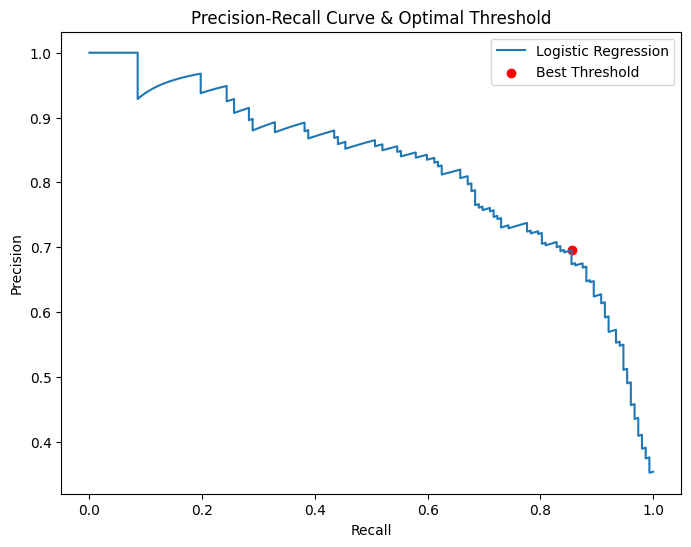

In [14]:
# ==============================================================================
# EXPERIMENT EXTRA 2: OPTIMIZAREA PRAGULUI (THRESHOLD TUNING)
# ==============================================================================
from sklearn.metrics import precision_recall_curve

# Obținem probabilitățile (nu clasele 0/1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculăm precizia și recall-ul pentru toate pragurile posibile
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Calculăm F1-Score pentru fiecare prag
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Găsim pragul care dă cel mai mare F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Pragul Standard (0.50) -> F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Pragul Optim ({best_threshold:.2f}) -> F1 Score Maxim: {best_f1:.4f}")

# Facem predicții noi cu noul prag
y_pred_new = (y_proba >= best_threshold).astype(int)

print("\n--- Performanță cu Noul Prag ---")
print(f"Recall Vechi: {recall_score(y_test, y_pred):.4f} -> Recall Nou: {recall_score(y_test, y_pred_new):.4f}")
print(f"Precision Veche: {precision_score(y_test, y_pred):.4f} -> Precision Nouă: {precision_score(y_test, y_pred_new):.4f}")

# Vizualizare Curba Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Logistic Regression')
plt.scatter(recalls[best_idx], precisions[best_idx], marker='o', color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve & Optimal Threshold')
plt.legend()
plt.show()

In [15]:
# ==============================================================================
# EXPERIMENT EXTRA 1: TESTARE L1 (LASSO) VS L2 (RIDGE)
# ==============================================================================

# Modificăm grila pentru a testa și penalizarea L1
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],       # Testăm ambele: L1 elimină variabile, L2 doar le micșorează
    'clf__solver': ['liblinear']        # 'liblinear' este obligatoriu pentru L1
}

# Rulăm din nou GridSearch cu noua grilă
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
# Dacă best_params_ spune 'penalty': 'l1', înseamnă că Lasso a câștigat!

# Verificăm câți coeficienți au devenit ZERO (doar dacă a câștigat L1 sau e un model antrenat cu L1)
best_model = grid.best_estimator_
coefs = best_model.named_steps['clf'].coef_.flatten()
zero_feat_count = np.sum(coefs == 0)
print(f"Număr de trăsături eliminate (Coeficient = 0): {zero_feat_count} din {len(coefs)}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Număr de trăsături eliminate (Coeficient = 0): 33 din 53
